# Binary Classifier

## Date: February 9, 2020

Binary classifier to classify the pages from the the 8k+ papers extracted from aminer as metioning or not the use of a dataset.

This classfier is then gradually improve using active learning strategies.

In [120]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.feature_selection import chi2
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pickle

In [2]:
with open('labeled_sample/Acoustic radiation force imaging sonoelastography for noninvasive staging of liver fibrosis..pdf_page_0.json') as json_file:
    smp = json.load(json_file)

In [3]:
list(smp.values())[0]

0

In [4]:
list(smp.keys())[0]

'www.wjgnet.comOnline Submissions: wjg.wjgnet.com                              World J Gastroenterol  2009 November 28; 15(44): 5525-5532wjg@wjgnet.com                                                        World Journal of Gastroenterology  ISSN 1007-9327doi:10.3748/wjg.15.5525                                                                                          © 2009 The WJG Press and Baishideng. All rights reserved. ORIGINAL ARTICLES ORIGINAL ARTICLEAcoustic radiation force imaging sonoelastography for Carmen Fierbinteanu-Braticevici, Dan Andronescu, Radu Usvat, Dragos Cretoiu, Cristian Baicus, Gabriela MarinoschiCarmen Fierbinteanu-Braticevici, Dan Andronescu, Radu Usvat, Medical Clinic ˛Ÿ and Gastroenterology, University Hospital, 050094 Bucharest, RomaniaDragos Cretoiu, Department of Cellular and Molecular Medicine, ﬁCarol Davilaﬂ University of Medicine and Pharmacy, 050094 Bucharest, RomaniaCristian Baicus, Department of Internal Medicine and Réseau d™Epidémiologie Clinique 

In [5]:
d = {}
for filename in os.listdir('labeled_sample'):
    with open('labeled_sample/' + filename) as sample:
        try: smp = json.load(sample, encoding='utf-32')
        except: print('pass')
    try: d.update(smp)
    except: pass

pass
pass


In [6]:
len(d)

186

In [7]:
dtf = pd.DataFrame.from_dict(d, orient='index').reset_index(drop=False).rename(columns={'index':'text',
                                                                                       0:'label'})

In [10]:
dtf.head(3)

,text,label
0,International Journal of Commun...,1
1,International Journal of Computer Applications...,0
2,816. Conclusions This thesis described the t...,0


Text(0.5, 1.0, 'Distriution of the lenght of the texts used')

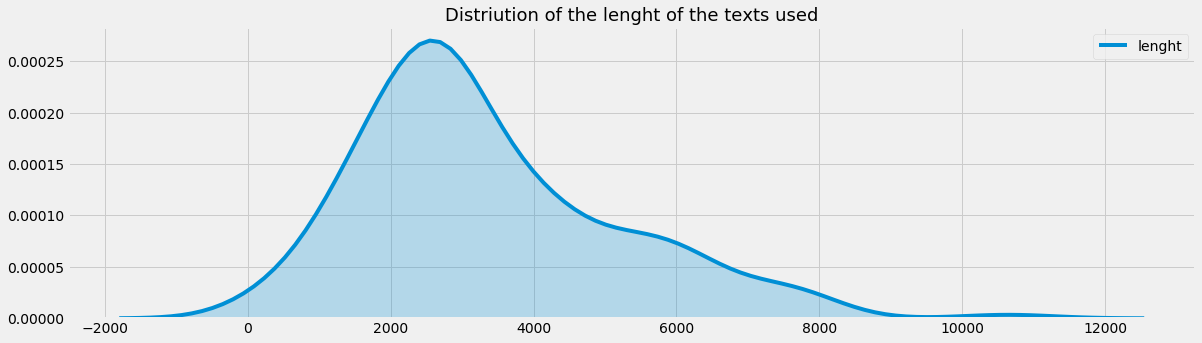

In [11]:
dtf_ = dtf.copy()
plt.style.use('fivethirtyeight')
dtf_['lenght'] = dtf_['text'].apply(lambda x: len(x))
plt.figure(figsize=(18,5))
sns.kdeplot(dtf_['lenght'], shade=True)
plt.title('Distriution of the lenght of the texts used', size=18)

Text(0.5, 1.0, 'Class repartition for text with (label 0) or without (label 1) a dataset mentioned')

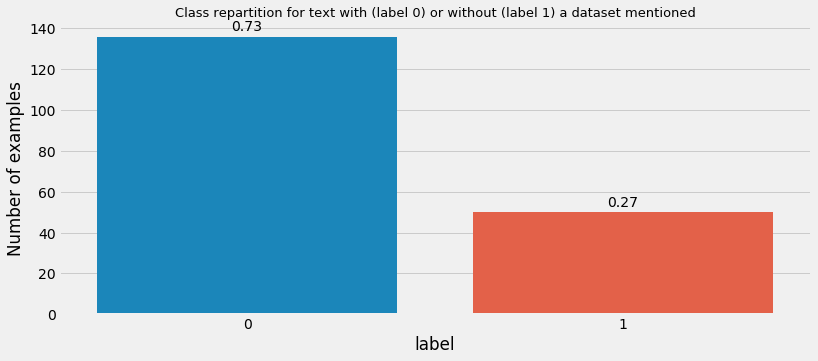

In [26]:
dtf_grouped = dtf.groupby('label').count()
plt.figure(figsize=(12,5))
ax = sns.barplot(x=dtf_grouped.index, y="text", data=dtf_grouped)
total = float(len(dtf))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center") 
plt.ylabel('Number of examples')
plt.title('Class repartition for text with (label 0) or without (label 1) a dataset mentioned', size=13)

In [13]:
dtf_grouped

,text
label,
0,136
1,50


## I. Vectorization

### Preprocess - Cleaning
- remove numbers
- remove punctuation
- convert to lowercase

In [4]:
import string

In [46]:
txt = list(smp.keys())[0]

In [47]:
txt

'  AppendixEPA conducted a comprehensive analysis of the emission impacts of biodiesel using heavy-duty, in-use diesel chassis and engine exhaust emissions data.  The emission impacts on NOx, PM, HC, and CO of 20 volume percent biodiesel fuels produced from various animal- and plant-based feedstock materials tested under several cycles in this analysis. v '

In [56]:
txt = txt.replace("\r", " ")
txt = txt.replace("\n", " ")
txt = txt.replace("    ", " ")
txt = txt.replace('"', '')
txt = txt.lower()
txt = txt.replace("'s", "")

#remove punctuation
txt = txt.translate(str.maketrans('', '', string.punctuation))

### Tokenization

In [35]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(txt)

### Stop Words

In [59]:
# Loading the stop words in english
Stopwords = set(stopwords.words('english'))
#removing stop words
tokens = [token for token in tokens if token not in Stopwords and len(token)>=3]

### Token normalization (lemmatization)

In [48]:
lem = nltk.WordNetLemmatizer()
txt = ' '.join(lem.lemmatize(token) for token in tokens)

### Mapping it through the dataset

In [60]:
def preprocess_text(txt):
    #clean text
    txt = txt.replace("\r", " ")
    txt = txt.replace("\n", " ")
    txt = txt.replace("    ", " ")
    txt = txt.replace('"', '')
    txt = txt.lower()
    txt = txt.replace("'s", "")

    #remove punctuation
    txt = txt.translate(str.maketrans('', '', string.punctuation))
    
    #tokenization
    tokenizer = nltk.tokenize.TreebankWordTokenizer()
    tokens = tokenizer.tokenize(txt)
    
    #stop words
    # Loading the stop words in english
    Stopwords = set(stopwords.words('english'))
    #removing stop words
    tokens = [token for token in tokens if token not in Stopwords and len(token)>=3]
    
    #Lemmatization
    lem = nltk.WordNetLemmatizer()
    txt = ' '.join(lem.lemmatize(token) for token in tokens)
    
    return txt

In [61]:
dtf['text'] = dtf['text'].apply(preprocess_text)

## II. Baseline Model

It's helpful to start a modeling experiment trying out a couple of reliable baselines. Simple is better and it is key to understand how much we are gaining in terms of performance by adding extra complexity. 

As a result, let us start by trying out one of the simplest models out there for text classification. That is, a sparse linear model that gives a weight to each token and adds up all of the results, regardless of the order. The fact that we don't care about the order of the words in the sentence is the reason why this method is generally known as a Bag-of-Words (BOW) approach. 

https://colab.research.google.com/drive/1oXjNYSJ3VsRvAsXN4ClmtsVEgPW_CX_c?hl=en#scrollTo=MwCuemrKvq94

### Train test split

W use a test set to prove the quality of our models for future use (scaling it to new unseen papers). 

We can do Cross Validation in the train set in order to tune the hyperparameters and then test performance on the unseen data of the test set.

In the split, we make sure to stratify the split by the label categories since we have an imbalanced dataset (we don't want the training set to have a different class proportion than the test set).

In [64]:
X_train, X_test, y_train, y_test = train_test_split(dtf['text'], 
                                                    dtf['label'], 
                                                    test_size=0.15, 
                                                    random_state=42,
                                                    stratify=dtf['label'])

Let's review how our classes has been separated:

In [74]:
len(y_train)

158

In [76]:
sum(y_train)/len(y_train)

0.26582278481012656

In [77]:
len(y_test)

28

In [78]:
sum(y_test)/len(y_test)

0.2857142857142857

In [79]:
sum(y_test)

8

### Text representation

Here, in a baseline model evaluation, we are going to use TF-IDF representation. 

**TF-IDF**: *Tf-idf stands for term frequency-inverse document frequency. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.*

Source: http://www.tfidf.com/

**Parameters**:
- **ngram_range**: We will use unigrams, bigrams and trigrams 
- **max_df**: ignore terms that have a document frequency strictly higher than the given threshold *(float in range [0.0, 1.0] or int)*
- **min_df**: ignore terms that have a document frequency strictly lower than the given threshold *(float in range [0.0, 1.0] or int)*
- **max_features**: only consider the top max_features ordered by term frequency across the corpus

In [113]:
# Parameters
ngram_range = (1,3)
min_df = 0.05
max_df = 1.
max_features = 300

In [114]:
#Representation
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=True,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
print('Features train shape: ', features_train.shape)

features_test = tfidf.transform(X_test).toarray()
print('Features test shape: ', features_test.shape)

Features train shape:  (158, 300)
Features test shape:  (28, 300)


To see which unigrams, bigrams and trigrams are most correlated with each category, we use a Chi squared test:

In [104]:
for category_id, nme in enumerate(['No mention of dataset (label 0)', 'Mention of dataset (label 1)']):
    print(category_id)
    features_chi2 = chi2(features_train, y_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print("# '{}' category:".format(nme))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-2:])))

0
# 'No mention of dataset (label 0)' category:
  . Most correlated unigrams:
. report
. percent
. residue
. environmental
. survey
  . Most correlated bigrams:
. 
  . Most correlated trigrams:
. 
1
# 'Mention of dataset (label 1)' category:
  . Most correlated unigrams:
. report
. percent
. residue
. environmental
. survey
  . Most correlated bigrams:
. 
  . Most correlated trigrams:
. 


In [115]:
feature_names = np.array(tfidf.get_feature_names())
unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
trigrams = [v for v in feature_names if len(v.split(' ')) == 3]

In [116]:
bigrams

[]

In [117]:
trigrams

[]

### Saving our representations

In [118]:
if not os.path.exists('Pickles'): os.mkdir('Pickles')

In [121]:
# X_train
with open('Pickles/X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
# X_test    
with open('Pickles/X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
# y_train
with open('Pickles/y_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)
    
# y_test
with open('Pickles/y_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)
    
# df
with open('Pickles/dtf.pickle', 'wb') as output:
    pickle.dump(dtf, output)
    
# features_train
with open('Pickles/features_train.pickle', 'wb') as output:
    pickle.dump(features_train, output)

# labels_train
with open('Pickles/labels_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)

# features_test
with open('Pickles/features_test.pickle', 'wb') as output:
    pickle.dump(features_test, output)

# labels_test
with open('Pickles/labels_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)
    
# TF-IDF object
with open('Pickles/tfidf.pickle', 'wb') as output:
    pickle.dump(tfidf, output)

## III. Evaluation

## TODO
- use POS as features in the model
- use NER as features in the model